<div style="background-color:	#216375 ; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">Deep Learning - Karaoke klassificatie</h1>
<b style="color:black"> Kaggle: Yoyoyoghurt(teamnaam), JortAkershoek, juliaboschman, Sam Keesen </b>
   
<b style="color:white"> Jort Akershoek, Julia Boschman, Sam Keesen</b>
    </div>

<a name='start'></a>

## Table of contents

1. [H1: Inleiding](#1.0)
2. [H2: EDA](#2.0)
    - [&sect;2.1: Audio fragmenten](#2.1)
    - [&sect;2.2: Eigenschappen audio fragmenten](#2.2)
    - [&sect;2.3: Songteksten](#2.3)
    - [&sect;2.4: Conclusie EDA](#2.4)
3. [H3: LSTM voor audioclips](#3.0)
    - [&sect;3.1: Feature engineering](#3.1)
    - [&sect;3.2: Het model](#3.2)
    - [&sect;3.3: Modelarchitectuur](#3.3)
    - [&sect;3.4: Stappen feature engineering](#3.4)
    - [&sect;3.5: Onderbouwing keuzes parameters](#3.5)
    - [&sect;3.6: Geschikte loss functie en optimizer](#3.6)
    - [&sect;3.7: Model trainen](#3.7)
    - [&sect;3.8: Loss visualisatie](#3.8)
    - [&sect;3.9: Functie voor kaggle](#3.9)
4. [H4: LSTM voor songteksten](#4.0)
    - [&sect;4.1: Het model](#4.1)
    - [&sect;4.2: Modelarchitectuur](#4.2)
    - [&sect;4.3: Onderbouwing keuzes parameters](#4.3)
    - [&sect;4.4: Datapipeline met data preprocessing, feature engineering, of/en data augmentation](#4.4)
    - [&sect;4.5: Model trainen](#4.5)
5. [H5: Transformer voor songteksten](#5.0)
    - [&sect;5.1: Het model](#5.1)
    - [&sect;5.2: Fine-tuning Hugging Face](#5.2)
    - [&sect;5.3: Naam modelarchitectuur en dataset](#5.3)
    - [&sect;5.4: Voordelen vooraf getrainde tekst modellen](#4.4)
    - [&sect;5.5: Stappen finetunen vooraf getraind model en motivaties](#5.5)
6. [H6: Model naar keuze](#6.0)
    - [&sect;6.1: Het model](#6.1)
    - [&sect;6.2: Modelarchitectuur](#6.2)
    - [&sect;6.3: Uitleg keuzes model](#6.3)
7. [H7: Bevindingen](#7.0)
    - [&sect;7.1: Samenvatting van de uitkomst](#7.1)
8. [H8: Conclusie en aanbevelingen](#8.0)
    - [&sect;8.1: Uitdagingen modelleringsproces](#8.1)
    - [&sect;8.2: Prestaties modelarchitecturen](#8.2)
    - [&sect;8.3: Beste model audio en tekst](#8.3)
    - [&sect;8.4: Genres makkelijk te voorspellen met audio en tekst](#8.4)
    - [&sect;8.5: Advies voor app](#8.5)
    - [&sect;8.6: Conceptuele uitbreiding voor systeem](#8.6)
9. [H9: Literatuurlijst](#9.0)

In [1]:
#alle nodige imports
import os
import wave
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf
from IPython import display
from tensorflow import keras
import IPython.display as ipd
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization

In [2]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

Voor het plotten van de model architectuur voeren wij aan het begin van ons notebook een regel code uit die verwijs naar de plek waar het bestand staat opgeslagen. Zo kunnen wij makkelijk iedere model architectuur laten zien wanneer deze getoond moet worden, na elk opgesteld model.

[Back to the top](#start)
<a name='1.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: Inleiding</strong></h2>
</div>

Voor het vak Deep Learning wordt er in dit portfolio onderzoek gedaan naar de werking en toepassing van verschillende vormen van neurale netwerken. De opdracht voor dit portfolio is het voorspellen van genres van liedjes met de hulp van neurale netwerken. Dit kunnen neurale netwerken zijn die alleen werken met tekst data, juist alleen met audio data of zelfs met beide. Er worden 4 verschillende neurale netwerken gebruikt in dit notebook en dat zijn als volgt:

- LSTM neuraal netwerk, alleen audio data.
- LSTM neuraal netwerk, alleen tekst data.
- Transformer model, alleen tekst data.
- Een model naar keuze, kan zowel audio als tekst data, of beide.

Aan het einde van het notebook gaan wij reflecteren op de manier(en) die het beste resultaat heeft geleverd voor ons vraagstuk. Hier zal worden gekeken naar het model, maar ook wat de reden zou kunnen zijn dat het model beter werkt dan de andere.

[Back to the top](#start)
<a name='2.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: EDA</strong></h2>
</div>

<a name='2.1'></a>
<h3>&sect;2.1: Audio fragmenten</h3>

Als aller eerste stap zullen wij de audio data inladen, zodat wij deze later kunnen gebruiken in een LSTM model. Hierin verdelen wij de data onder train en validation data. Deze validation data wordt in de cel daaronder weer onderverdeeld in validation en test data. Wij hebben er voor gekozen om de data te verwerken in batches van 8, zodat het model niet te veel kracht nodig heeft om te kunnen runnen.

In [3]:
base_dir = "Train"

data_dir = pathlib.Path(base_dir)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=8,
    validation_split=0.2,
    seed=0,
    output_sequence_length=30*22050,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [4]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Na het bekijken van de data zien wij dat er 8 genres in onze data zitten. Dit zijn de genres blues, country, disco, hiphop, metal, pop, reggae en rock. Wij zullen later in het notebook modellen samenstellen die de data kan onderscheiden in deze 8 verschillende genres.

In [5]:
test_dir = "Test"

data_dir_test = pathlib.Path(test_dir)

test_ds_kaggle = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir_test,
    batch_size=8,
    seed=0,
    output_sequence_length=30*22050,
    label_mode=None)

Found 129 files belonging to 1 classes.


Om onze modellen te kunnen testen moeten wij als groep mee doen aan een Kaggle competitie. Er is voor dit testen een aparte dataset gemaakt, en die wordt los gebruikt als nog niet geziene data. Daarom laden wij dit op een iets andere manier in, zodat er gewoon 1 dataset overblijft. Het valt op dat er nu aangegeven staat dat er maar 1 class toebehoord aan de data, maar dat komt omdat wij met ons model de goede genres nog aan de data toe moeten wijzen.

In [6]:
def squeeze(audio, labels=None):
    """
    Squeezes the last dimention of the input audio tensor.
    
    Parameters:
    -----------
    audio, (tf.Tensor): The audio file that needs to be squeezed.
    labels, (tf.Tensor, optional): The labels corresponding to the audio files.
        default=None.
        
    Returns:
    --------
    A tuple containing the squeezed audio files and the corresponding labels if provided.
    """
    audio = tf.squeeze(audio, axis=-1)
    if labels is not None:
        return audio, labels
    else:
        return audio

Om uiteindelijk een model te kunnen trainen met de audio gegevens moet er een squeeze methode worden toegepast op de data. Zo wordt de data naar een kleinere dimensie gebracht en kunnen neurale netwerk modellen beter omgaan met de input data.

In [7]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
test_ds_kaggle = test_ds_kaggle.map(squeeze, tf.data.AUTOTUNE)

In [10]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(8, 661500)
(8,)


In [11]:
train_ds = train_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [12]:
test_ds_kaggle = test_ds_kaggle.cache().prefetch(tf.data.AUTOTUNE)

<a name='2.2'></a>
<h3>&sect;2.2: Eigenschappen audio fragmenten</h3>

Nu alle data is ingeladen willen we voor ieder genre een liedje laten horen. Dat doen we hier onder met een zelf gedefinieerde code die het eerste nummer pakt uit de map van het genre en hier het nummer klaar zet met een playbutton. Bij ieder lied staat de naam van het genre en de lengte van het fragment weergegeven. Ieder lied kan afgespeeld worden door op de playbutton te drukken.

In [13]:
def get_first_audio_per_class(class_dir):
    """
    Retrieve the first audio file path for each class within the given directory.

    Parameters:
    -----------
    class_dir (str or Path): Path to the directory containing subdirectories for each class,
        with audio files inside each class subdirectory.

    Returns:
    --------
    list: A list of tuples, where each tuple contains the class label and the path to the first
        audio file found within the corresponding class subdirectory.
    """
    class_audio_paths = []
    for label in os.listdir(class_dir):
        class_path = class_dir / label
        class_audio_files = list(class_path.glob('*.wav'))
        if class_audio_files:
            class_audio_paths.append((label, class_audio_files[0]))
    return class_audio_paths

In [14]:
first_audio_per_class = get_first_audio_per_class(data_dir)
html_code = ""
for genre, audio_path in first_audio_per_class:
    audio_length = sf.info(audio_path).duration
    html_code += f'<p>Genre: {genre}</p>'
    html_code += f'<p>Audio Length: {audio_length} seconds</p>'
    html_code += f'<audio controls><source src="{audio_path}" type="audio/wav"></audio>'
ipd.display(ipd.HTML(html_code))

Als eerst laten wij het eerste fragment horen van ieder genre die in onze dataset staat. Dit zijn allemaal audioclips van ongeveer 30 seconden. Het is belangrijk dat de code vanaf hierboven gerund wordt om de audiobestanden te kunnen beluisteren. Dan is het een simpele knop op de playbotton en hoor je het gehele fragment bij het genre.

In [20]:
def get_sampling_frequency(audio_file_path):
    """
    Get the sampling frequency (in Hertz) of the audio file.

    Parameters:
    -----------
    audio_file_path (Path): Path to the audio file.

    Returns:
    --------
    int: The sampling frequency of the audio file.
    """
    with wave.open(audio_file_path, 'rb') as audio_file:
        return audio_file.getframerate()

In [27]:
get_sampling_frequency(base_dir + "/blues/blues.00001.wav")

22050

Voor het berekenen van de sampling frequentie, het aantal samples per seconde, hebben wij een simpele functie gedefinieerd die de sampling frequentie kan berekenen van een audio bestand. Dit laten wij zien voor het eerste nummer in onze dataset, om aan te kunnen tonen wat de sampling frequentie is van onze data. Dit komt uit op een getal van 22050

https://stackoverflow.com/questions/43490887/check-audios-sample-rate-using-python

##### Korte conclusie audiofragmenten
Alle audio fragmenten zijn ongeveer 30 seconden en een sampling frequentie van 22050 Hz in ieder genre. Vandaar dat we de data inladen met: output_sequence_length=30*22050.

<a name='2.3'></a>
<h3>&sect;2.3: Songteksten</h3>

In [28]:
tekst = pd.read_csv("train.csv")
tekst

,filename,lyrics,genre
0,blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues
1,blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues
2,blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues
3,blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues
4,blues.00006.wav,My baby left me this morning\nPeople just arou...,blues
...,...,...,...
532,rock.00094.wav,[Chorus]\nDon’t stop\nIsn’t it funny how you s...,rock
533,rock.00096.wav,"[Verse 1]\nHer hair, soft drifted snow\nDeath ...",rock
534,rock.00097.wav,[Verse 1]\nYour knuckles whiten on the wheel\n...,rock
535,rock.00098.wav,[Verse 1]\nYou know it\nYou show it\nAnd the t...,rock


De kolommen bevatten het volgende:
- filename: De bestandsnaam wat koppelt aan de bestanden die aan de audio's verbonden zijn. LET OP: Bij de train dataset staan de genres in de naam van de bestanden, bij de audiobestanden staat in de plek van de genres het woord "train".
- lyrics: De songtekst die verbonden is aan het lied uit filename
- genre: Het genre van het lied die verbonden is aan het lied uit de filename

In [29]:
tekst.isna().sum()

filename    0
lyrics      0
genre       0
dtype: int64

Er zijn geen missende waardes in de dataset.

In [30]:
tekst["genre"].value_counts()

rock       79
hiphop     73
pop        73
country    72
disco      68
metal      64
reggae     64
blues      44
Name: genre, dtype: int64

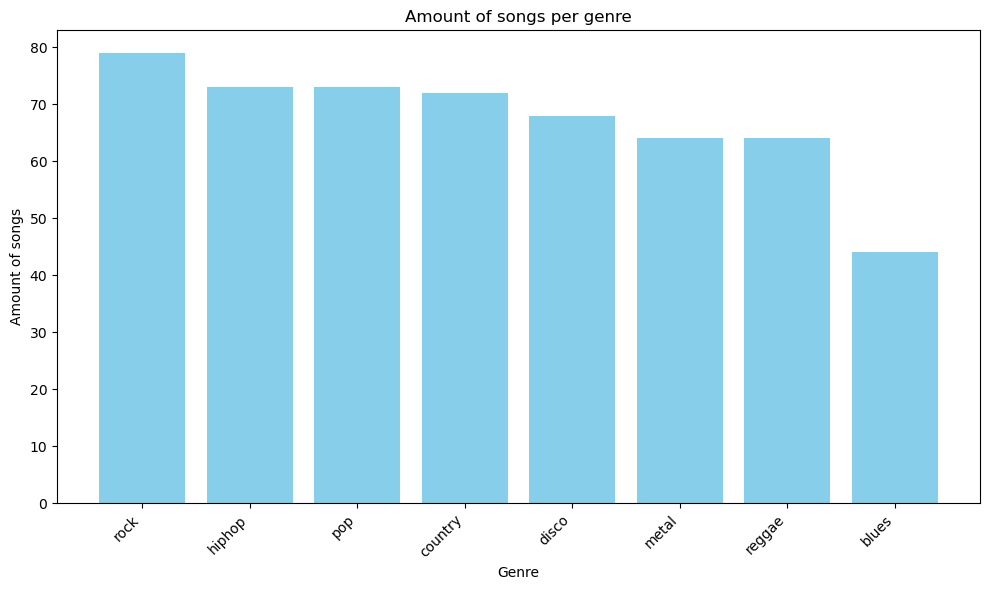

In [40]:
genres = tekst["genre"].value_counts().index
aantallen = tekst["genre"].value_counts().values

plt.figure(figsize=(10, 6))
plt.bar(genres, aantallen, color='skyblue')
plt.title('Amount of songs per genre')
plt.xlabel('Genre')
plt.ylabel('Amount of songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In de dataset zitten in totaal 8 genres, waarvan de data niet helemaal goed is verdeeld. Zo zie je dat de genres rock, hiphop, pop en country ongeveer even veel liedjes heeft van ronde de 75. Het genre blues heeft echter maar 44 liedjes, dat is minder dan de helft, dus hopelijk zal dit niet voor problemen zorgen tijdens het trainen van de modelen.

In [33]:
tekst['lyrics_length'] = tekst['lyrics'].apply(lambda x: sum(len(line) for line in x))
tekst

,filename,lyrics,genre,lyrics_length
0,blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues,706
1,blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues,755
2,blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues,1456
3,blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues,1318
4,blues.00006.wav,My baby left me this morning\nPeople just arou...,blues,713
...,...,...,...,...
532,rock.00094.wav,[Chorus]\nDon’t stop\nIsn’t it funny how you s...,rock,793
533,rock.00096.wav,"[Verse 1]\nHer hair, soft drifted snow\nDeath ...",rock,1155
534,rock.00097.wav,[Verse 1]\nYour knuckles whiten on the wheel\n...,rock,1214
535,rock.00098.wav,[Verse 1]\nYou know it\nYou show it\nAnd the t...,rock,1002


Om te kunnen kijken op welke plekken er nog meer onderscheid is tussen de genres berekenen wij de lengte van een songtekst. Zo kunnen wij berekenen welk genre gemiddeld het meeste aantal woorden gebruikt in hun teksten en zo misschien betere voorspellingen kan doen.

In [34]:
tekst_lens = tekst.groupby("genre")["lyrics_length"].mean()
tekst_lens

genre
blues       893.704545
country    2174.333333
disco      2699.058824
hiphop     4677.986301
metal      4417.203125
pop        2312.410959
reggae     1638.734375
rock       1274.594937
Name: lyrics_length, dtype: float64

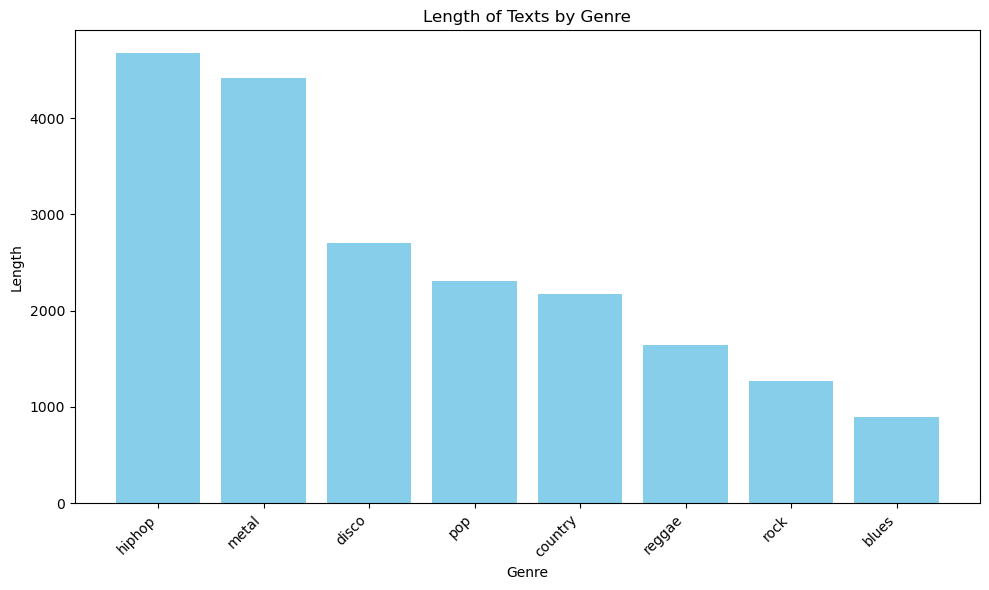

In [35]:
sorted_df = tekst_lens.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(sorted_df.index, sorted_df.values, color='skyblue')
plt.title('Length of Texts by Genre')
plt.xlabel('Genre')
plt.ylabel('Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Wanneer er gekeken wordt naar de gemiddelde lengtes van de teksten per genre valt het meteen op dat er een stuk meer tekst zit in liedjes met het genre hiphop en pop dan in liedjes als reggae, rock en blues. Het is goed om te zien dat hier zo'n groot verschil in zit, omdat dit hoop geeft op de voorspellingen die uiteindelijk gemaakt moeten worden.

In [38]:
def top_5_common_words(df):
    """
    Find the top 5 most common words in the lyrics for each genre in the dataframe.

    Parameters:
    -----------
    df (DataFrame): A pandas DataFrame containing 'genre' and 'lyrics' columns.

    Returns:
    --------
    dict: A dictionary where keys are genres and values are lists of the top 5 most common words
        in the lyrics associated with each genre.
    """
    top_5_per_genre = {}

    for genre, text in zip(df['genre'], df['lyrics']):
        words = text.lower().split()
        words = [word.strip('.,!?;:"()[]{}') for word in words]

        # Top 5 meest voorkomende woorden per genre
        top_5_words = Counter(words).most_common(5)
        top_5_per_genre[genre] = [word for word, freq in top_5_words]

    return top_5_per_genre

In [39]:
most_common = top_5_common_words(tekst)
for genre, common in most_common.items():
    print(f"De meest voorkomende woorden in het genre '{genre}' zijn: {common}")

De meest voorkomende woorden in het genre 'blues' zijn: ["i'm", 'your', 'iceman', 'my', 'baby']
De meest voorkomende woorden in het genre 'country' zijn: ['to', 'this', 'we', 'be', 'the']
De meest voorkomende woorden in het genre 'disco' zijn: ['hey', 'he', 'was', 'a', 'the']
De meest voorkomende woorden in het genre 'hiphop' zijn: ['the', 'fight', 'power', 'to', 'you']
De meest voorkomende woorden in het genre 'metal' zijn: ['the', 'on', 'yeah', 'come', 'a']
De meest voorkomende woorden in het genre 'pop' zijn: ['do', 'you', 'be', 'baby', 'always']
De meest voorkomende woorden in het genre 'reggae' zijn: ['capone', 'al', "don't", 'my', 'name']
De meest voorkomende woorden in het genre 'rock' zijn: ['the', 'this', 'is', 'one', 'for']


Als laatste onderscheid dat wij willen maken kijken wij nog naar de top 5 van de meest voorkomende woorden per genre. Hieruit kan niet een heel groot onderscheid gemaakt worden, omdat de top 5 bestaat uit random, veel voorkomende woorden en je ziet woorden als "the", "do"/"don't", "be" in meerdere teksten terug komen. Daarom verwachten wij niet dat het model met enkel de woorden goede voorspellingen kan maken.

https://chat.openai.com/c/bafd8dfa-3131-44be-a5da-6483beeb7f48

<a name='2.4'></a>
<h3>&sect;2.4: Conclusie EDA</h3>

Uit onze EDA zijn een aantal belangrijke punten naar boven gekomen. Zo weten wij dat ieder audio bestand ongeveer 30 seconden lang is. Dat is fijn wanneer wij met de data moeten gaan modelleren, omdat het dan een stuk sneller gaat dan met audio bestanden van 30 seconden. Daarnaast zijn wij er achter gekomen dat er een groot verschil is in de genres wanneer er gekeken wordt naar de lengte van de teksten van een lied. Gemiddeld heeft een hiphop nummer meer tekst van een blues nummer. Deze informatie laat ons geloven dat een model relatief goed kan voorspellen met tekst data als deze de lengte van de teksten mee neemt tijdens het trainen. Verder weten wij nu ook hoe veel genres in de dataset zitten, wat helpt bij het maken van een model. Zo weten wij precies wat de laatste (output) laag van ons model moet zijn. Om de data nog beter voor te bereiden op het trainen zijn er nog een aantal toevoegingen die gedaan kunnen worden om meer duidelijke verschillen te kunnen zien in de data. Deze voegen wij toe in het volgende hoofdstuk waar wij ook uiteindelijk de data gaan trainen en onze eerste voorspellingen gaan maken.

[Back to the top](#start)
<a name='3.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: LSTM voor audioclips</strong></h2>
</div>

<a name='3.1'></a>
<h3>&sect;3.1: Feature engineering</h3>

Voor het voorbereiden van de data hebben wij insprantie gehaald uit de lesopdracht van week 7, les 1 (LSTM_voor_timeseries_data_–_classificatie_van_audioclips, 2024)

http://localhost:8888/notebooks/Downloads/Jaar%202/Semester%202/Deep%20Learning/Week%207/Les%201/LSTM_voor_timeseries_data_%E2%80%93_classificatie_van_audioclips.ipynb

In [42]:
for audio_batch, label_batch in train_ds.take(1):
    print("Shape of an audio sample:", audio_batch[0].shape)

Shape of an audio sample: (661500,)


In [43]:
def get_spectrogram(waveform):
    """
    Convert a waveform into a spectrogram representation.

    Parameters:
    -----------
    waveform (Tensor): The input audio waveform.

    Returns:
    --------
    Tensor: The spectrogram representation of the input waveform.
    """
    spectrogram = tf.signal.stft(waveform, frame_length=512, frame_step=256)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Als eerste stap in het feature engineeren maken wij een functie aan die de spectrogram van ieder audio bestand berekend. Dit is een feature die veel kan zeggen over een bepaald audio bestand. In een andere paragraaf wordt er dieper ingegaan op de specrogrammen en de reden waarom wij deze hebben gekozen om toe te voegen aan onze data.

In [49]:
def make_spec_ds(ds):
    def map_func(audio, *args):
        """
        Map function to convert audio samples to spectrograms.

        Parameters:
        -----------
        audio: Audio waveform.
        *args: Additional arguments, if any.

        Returns:
        --------
        tuple or Tensor: If additional arguments are provided, returns a tuple containing
            the spectrogram and the first additional argument. Otherwise, returns just the spectrogram.
        """
        spectrogram = get_spectrogram(audio)
        if len(args) > 0:
            return spectrogram, args[0]
        else:
            return spectrogram
    return ds.map(
        map_func,
        num_parallel_calls=tf.data.AUTOTUNE)

Na het berekenen van de spectrogrammen bij de data moeten ze worden toegewezen aan de data. Dat gebeurd met de functie die hierboven is gedefinieerd.

In [50]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
test_spectrogram_ds_kaggle = make_spec_ds(test_ds_kaggle)

In [51]:
train_spectrogram_ds =train_spectrogram_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_spectrogram_ds_kaggle = test_spectrogram_ds_kaggle.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
for audio_batch, label_batch in train_spectrogram_ds.take(1):
    print("Shape of an audio sample:", audio_batch[0].shape)

Shape of an audio sample: (2582, 257, 1)


Na het maken van de functies moeten ze nog gebruikt worden. In de cellen hierboven worden eerst de spectrogrammen berekend van de audio bestanden. In de cel daaronder worden de waardes toegevoegd aan de data en als laatste wordt er weergeven hoe de data er uit ziet na het toevoegen van de spectrogrammen.

In [53]:
def spectrogram_to_mfcc(spectrograms, num_mel_bins=128, num_coefficients=20, sample_rate=16000):
    """
    Convert a batch of spectrograms to a batch of 1D time series of MFCCs.

    Parameters:
    - spectrograms: A TensorFlow Tensor representing a batch of spectrograms with shape (batch_size, 311, 257, 1).
    - num_mel_bins: Number of Mel bins to use.
    - num_coefficients: Number of MFCC coefficients to return.
    - sample_rate: Sample rate of the audio.

    Returns:
    - A TensorFlow Tensor containing the MFCCs with shape (batch_size, num_frames, num_coefficients).
    """
    spectrograms = tf.squeeze(spectrograms, axis=-1)
    stfts_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrograms.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sample_rate / 2)
    mel_spectrograms = tf.tensordot(spectrograms, stfts_to_mel_matrix, 1)
    
    mel_spectrograms.set_shape(spectrograms.shape[:-1] + (num_mel_bins,))
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_coefficients]
    return mfccs

Daarna kiezen wij er voor om nog een feature toe te voegen aan onze data, ook wel de MFCC's. Meer uitleg over de reden van de keuze van deze feature en uitleg wat deze feature inhoudt komt in een latere paragraaf aan bot. In de functie hierboven maken wij alleen nog maar de waardes van de features aan.

In [54]:
def make_MFCC_ds(ds):
    """
    Convert a spectrogram dataset into a dataset of Mel-frequency cepstral coefficients (MFCCs).

    Parameters:
    ds (tf.data.Dataset): The input spectrogram dataset.

    Returns:
    --------
    tf.data.Dataset: The dataset of MFCCs.
    """
    def map_func(spectrogram, *args):
        mfcc = spectrogram_to_mfcc(spectrogram)
        if len(args) > 0:
            return mfcc, args[0]
        else:
            return mfcc
    return ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

Na het berekenen van de MFCC's moeten ze ook nog toegevoegd worden aan de data, wat gebeurd in de functie hierboven. 

In [55]:
train_MFCC_ds = make_MFCC_ds(train_spectrogram_ds)
val_MFCC_ds = make_MFCC_ds(val_spectrogram_ds)
test_MFCC_ds = make_MFCC_ds(test_spectrogram_ds)
test_MFCC_ds_kaggle = make_MFCC_ds(test_spectrogram_ds_kaggle)

In [56]:
for example_MFCC, example_MFCC_labels in train_MFCC_ds.take(1):
    break

In [57]:
example_MFCC

<tf.Tensor: shape=(8, 2582, 13), dtype=float32, numpy=
array([[[  6.6678653 ,   2.9753618 ,  -0.06713956, ...,  -2.494177  ,
          -1.2334949 ,  -0.92850125],
        [  7.4314632 ,   2.9059558 ,  -0.613349  , ...,  -2.0559812 ,
          -1.2191489 ,  -1.4243413 ],
        [  6.461703  ,   3.6389782 ,   1.3369415 , ...,  -1.8989615 ,
          -1.8076395 ,  -2.0802813 ],
        ...,
        [ -8.061279  ,   0.5712976 ,   0.07056922, ...,  -1.2907891 ,
          -1.0244616 ,  -0.27767983],
        [-11.551893  ,  -0.48121053,   0.19381702, ...,  -0.23644543,
          -0.2844853 ,   0.2634227 ],
        [-13.167819  ,   0.9324912 ,   0.7912486 , ...,  -1.2018069 ,
          -0.990943  ,  -1.3989909 ]],

       [[  3.17915   ,  -0.17445137,  -2.43258   , ...,  -4.7581596 ,
           0.99423754,  -1.0728409 ],
        [  3.7056408 ,  -1.0910015 ,  -3.3855271 , ...,  -4.4603333 ,
           0.41513225,  -1.5911314 ],
        [  4.2581596 ,   0.1307602 ,  -2.2055476 , ...,  -3.902214

In [58]:
train_MFCC_ds = train_MFCC_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_MFCC_ds = val_MFCC_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_MFCC_ds = test_MFCC_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_MFCC_ds_kaggle = test_MFCC_ds_kaggle.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [59]:
for audio_batch, label_batch in train_MFCC_ds.take(1):
    print("Shape of an audio sample:", audio_batch[0].shape)

Shape of an audio sample: (2582, 13)


In de cellen hierboven worden de twee functies van de MFCC's toegepast. Als eerste gebruiken wij de functie die de MFCC's bij de data berekend. Daarna voegen wij deze waardes toe aan de data zodat wi nu overblijven met een dataset van audio bestanden inclusief de spectrogrammen en de MFCC's. Ook maken wij de variabelen example_MFCC en example_MFCC_labels aan, om te kijke hoe de data er nu uit ziet. De shape hiervan wordt gebruikt als input shape van ons eerste model. Als laatste printen wij de shape van onze data hoe het er nu uitziet, na het toevoegen van de MFCC's.

<a name='3.2'></a>
<h3>&sect;3.2: Het model</h3>

In [61]:
input_shape = example_MFCC.shape[1:]

model_lstm = models.Sequential([
    layers.Input(shape=input_shape),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
    Dropout(0.5),
    BatchNormalization(),
    Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
    Dropout(0.5),
    BatchNormalization(),
    Bidirectional(LSTM(16, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))),
    Dropout(0.5),
    BatchNormalization(),
    Dense(8, activation='softmax')
])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 2582, 128)         39936     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 2582, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 2582, 128)         512       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 2582, 64)          41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 2582, 64)          0         
                                                        

<a name='3.3'></a>
<h3>&sect;3.3: Modelarchitectuur</h3>

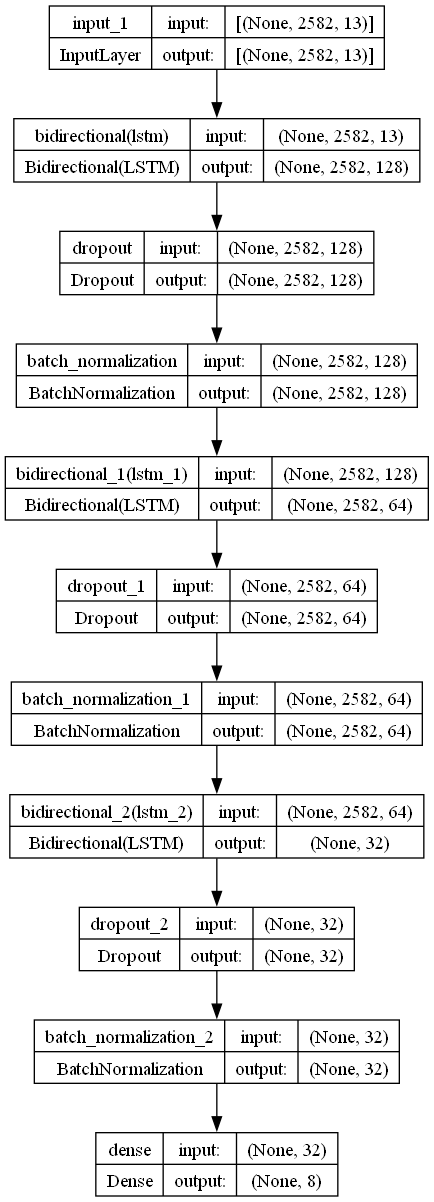

In [62]:
tf.keras.utils.plot_model(model_lstm, to_file='LSTM_audio.png', show_shapes=True, show_layer_names=True)

<a name='3.4'></a>
<h3>&sect;3.4: Stappen feature engineering</h3>

Voor het voorspellen van genres van een lied met audio data is het handig om een aantal features toe te voegen aan de data, zodat er meer data gebruikt wordt tijdens het trainen en er betere voorspellingen gedaan kunnen worden. Als eerst hebben wij er voor gekozen om spectorgrams toe te voegen aan onze audio bestanden. Een spectrogram is een visuele representatie van een audiobestand met 3 features. Als eerst heb je op de X-as de tijd van het bestand, op de y-as de frequentie van het audiobestand en de kleur geeft de amplitude aan van de audiobestanden. Deze kleur kan lichtere of donkere tonen aangeven wat dan ook aan geeft of er verschil is in de data. Door het toevoegen van spectrogrammen aan je trainingsdata kunnen er makkelijker patronen herkent worden wat uiteindelijk resulteert in betere voorspellingen (Seeing Sound: What Is A Spectrogram?, 2018).

Naast het toevoegen van de spectrogrammen hebben wij er ook voor gekozen om de MFCC's van de audiobestanden toe te voegen aan de data. MFCC staat voor Mel-frequency cepstrum wat slaat op een groep features, vaak tussen de 10 en de 20, die de algemene vorm van de spectrale envelop beschrijven. Wij hebben er voor gekozen om 20 features toe te voegen, zodat er meer data gebruikt kan worden tijdens het trainen. Onze data bevatte eerst namelijk alleen de audiobestanden en de spectrogrammen. De MFCCs worden dan ook afgeleid uit de data van de spectrogrammen. (Deruty, 2022)

Na creëren van alle functies voor het toevoegen van de nieuwe feautres worden ze gebruikt en hebben we een nieuwe dataset met een hoop nieuwe features dus kunnen helpen bij het correct voorspellen van de genres bij de nummers. Dit doen wij ook voor de uiteindelijke test data, zodat deze gebruikt kan worden om onze prestaties te testen op kaggle.

Spectrogram: https://blogs.bl.uk/sound-and-vision/2018/09/seeing-sound-what-is-a-spectrogram.html
MFCC: https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779

<a name='3.5'></a>
<h3>&sect;3.5: Onderbouwing keuzes parameters</h3>

- Sequential: Om een LSTM model te maken beginnen we met het initialiseren van een Sequential model. Wij hebben er voor gekozen om een aantal features toe te voegen aan de data waardoor wij als input shape de shape gebruiken van de "example_MFCC" variabele. Hierin is de shape te vinden van de uiteindelijke trainingsdata.

- Om een goed model te trainen is het goed om lagen te maken met neuronen met een even getal. Het beste is wanneer het getal van de volgende laag de helft is van de laag ervoor, omdat de data op deze manier het beste leert van de vorige data. Wij hebben er voor gekozen om een model te maken met 3 Bidirectional LSTM lagen. Een normale LSTM laag kijkt alleen naar één laag terug in het verleden terwijl een Bidirectional LSTM laag kijkt naar zowel één laag uit het verleden en één laag in de toekomst. Wij hebben er voor gekozen om deze laag te gebruiken, omdat het meer informatie gebruikt tijdens het trainen wat voor ons voordelig is. 
    - Lagen: Wij beginnen in de eerste laag met 64 neuronen, in de tweede laag met 32 neuronen en in de derde laag met 16 neuronen. Wij bouwen steeds af in het aantal neuronen zodat het model goed de patronen in de data kan leren. Wij beginnen bij de 64, omdat onze output laag uiteindelijk 8 genres moet kunnen voorspellen, wat weer de helft is van 16, waar we in de derde laag op uit komen. Als laatste hebben we aan deze LSTM lagen ook een regulizer toegevoegd. De regulizer die wij hebben toegevoegd is de L2, die gewichten van features richting de 0 brengt maar wel behoudt, wat goed is voor onze data, omdat wij niet veel data hebben, dus geen informatie willen verliezen. 
    - Dropout: Tussen elk van de Bidirectional LSTM lagen wordt er een dropout laag toegevoegd. Een dropout van 0.5 houdt in dat er tijdens het trainen 50 procent van de nodes, van die laag, wordt uitgezet en de nodes die uitvallen zijn random gekozen.
    - Normalization: Naast het toevoegen van een dropout laag tussen alle Bidirectional LSTM lagen, wordt er ook een Batch Normalisatie toegevoegd tussen iedere laag. Hierin wordt de input data genormaliseerd waardoor het gemiddelde 0 is en de standaarddeviatie 1.
    - Ouput laag: Om het model af te sluiten moet er een output laag aangemaakt worden die aangeeft hoeveel mogelijke uitkomsten het model zou moeten kunnen voorspellen. Voor de opdracht moeten wij genres voorspellen wat een totaal heeft van 8 genres. Daarom hebben wij een output laag van 8, met een activatiefunctie "softmax". Dit is de activatifunctie die gebruikt wordt wanneer er meerdere categorieën voorspeld moeten worden.
   
Na het toevoegen van al deze lagen aan het model kan het model getraind worden op onze data, die uiteindelijk gebruikt kan worden op de ongeziene data om de genres te voorspellen.

<a name='3.6'></a>
<h3>&sect;3.6: Geschikte loss functie en optimizer</h3>

Buiten het opstellen van het aantal lagen, aantal neuronen, activatie functies en het aantal epochs is het ook belangrijk om uit te zoeken welke loss functie en optimizer het best gebruikt kan worden voor ons model.

- Loss functie: Voordat we een goede loss functie kunnen kiezen voor ons model is het als aller eerste belangrijk dat er gekeken wordt naar de opdracht. Voor dit portfolio is het de bedoeling om met de hulp van data voorspellingen te maken van een bepaald genre waar een liedje tot toe behoord. Het aantal genres dat wij hebben in onze train dataset is 8. Dat wilt zeggen dat wij bezig zijn met een classificatie taak waar 8 verschillende uitkomsten mogelijk zijn. Daarom kiezen wij er voor om gebruik te maken van de loss functie "sparse categorical cross entropy". De reden dat wij niet gewoon categorical cross entropy gebruiken is, omdat deze loss functie alleen one-hot encoded labels accepteert. Wij maken gebruik van simpele integer labels die wel geaccepteerd worden met een sparse categorical cross entropy loss functie. Op deze manier kunnen wij ons model goed trainen met de correcte loss functie.

- Optimizer: De optimizer die wij gebruiken voor ons LSTM audio model is de Adam optimizer. Dit staat voor Adaptive moment estimator en kan goed omgaan met ruis in de data. Ook hebben wij er voor gekozen om deze optimizer te kiezen, omdat hij snel en efficiënt werkt met grote hoeveelheden data. Wij werken voor deze portfolio opdrachten met audio data van 30 seconde, waar features aan zijn toegevoegd. Dit betekent dan ook dat de data groter en groter is geworden en het veel tijd nodig heeft om te trainen. Hierom hebben wij ervoor gekozen om ons model te compileren met de Adam optimizer.
    - Werking van de optimizer Adam: Adam houdt tijdens het trainen twee momenten van de gradiënt bij. Ten eerste berekent het, net als de SGD-optimizer, het gemiddelde van de gradiënten. Daarnaast berekent het ook het gemiddelde van de kwadraten van de gradiënten, een extra stap die de SGD-optimizer niet kent. Vervolgens past Adam verschillende leersnelheden toe op elk gewicht, gebaseerd op deze momenten. Bovendien gebruikt Adam informatie over hoe de loss functie verandert ten opzichte van de verschillende parameters van het model om te beslissen welke richting hij moet nemen om de fout te verkleinen. Het past de grootte van de stapjes aan op basis van de grootte van de gradiënt en past ook de richting aan om de meest efficiënte weg naar beneden te vinden. Op deze manier kan Adam snel en slim leren om het model te verbeteren.
    
- Metrics: De uiteindelijke metrics die wij gebruiken om ons model te trainen in de accuracy. De reden dat wij deze metric gebruiken is, omdat wij willen weten hoe goed ons model presteert door te kijken hoe veel van de liedjes een goed voorspellend genre hebben gekregen. 

<a name='3.7'></a>
<h3>&sect;3.7: Model trainen</h3>

In [63]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [64]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])
history_lstm = model_lstm.fit(train_MFCC_ds, epochs=100, validation_data=val_MFCC_ds, batch_size=30)

Epoch 1/100
54/54 [==============================] - 198s 3s/step - loss: 6.4999 - accuracy: 0.1837 - val_loss: 5.8654 - val_accuracy: 0.3529
Epoch 2/100
54/54 [==============================] - 210s 4s/step - loss: 5.8466 - accuracy: 0.2698 - val_loss: 5.4208 - val_accuracy: 0.3529
Epoch 3/100
54/54 [==============================] - 222s 4s/step - loss: 5.4151 - accuracy: 0.2953 - val_loss: 5.0100 - val_accuracy: 0.3529
Epoch 4/100
54/54 [==============================] - 261s 5s/step - loss: 4.9706 - accuracy: 0.3395 - val_loss: 4.6483 - val_accuracy: 0.3137
Epoch 5/100
54/54 [==============================] - 237s 4s/step - loss: 4.6255 - accuracy: 0.3628 - val_loss: 4.3468 - val_accuracy: 0.4118
Epoch 6/100
54/54 [==============================] - 224s 4s/step - loss: 4.3057 - accuracy: 0.3837 - val_loss: 4.0997 - val_accuracy: 0.3333
Epoch 7/100
54/54 [==============================] - 220s 4s/step - loss: 3.9965 - accuracy: 0.3977 - val_loss: 3.9588 - val_accuracy: 0.3137
Epoch 

In [65]:
last_acc_audio = history_lstm.history['val_accuracy'][-1]
print("Last Validation Accuracy Audio LSTM:", last_acc_audio)

Last Validation Accuracy Audio LSTM: 0.37254902720451355


<a name='3.8'></a>
<h3>&sect;3.8: Loss visualisatie</h3>

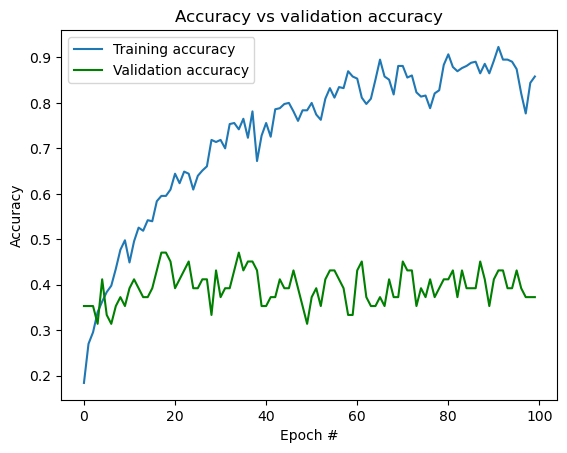

In [67]:
plt.plot(history_lstm.history['accuracy'], label='Training accuracy')
plt.plot(history_lstm.history['val_accuracy'], 'g', label='Validation accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('Accuracy vs validation accuracy')
plt.legend()
plt.show()

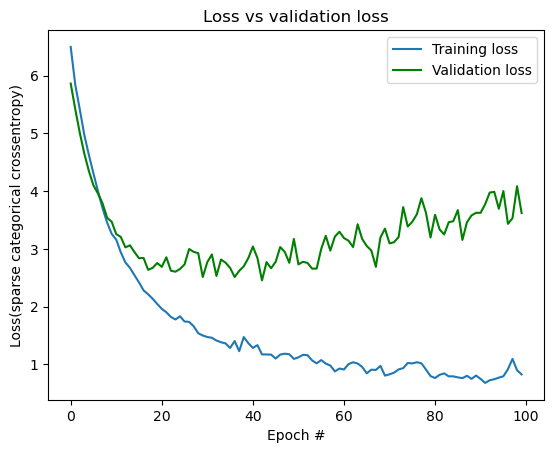

In [68]:
plt.plot(history_lstm.history['loss'], label='Training loss')
plt.plot(history_lstm.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss(sparse categorical crossentropy)')
plt.title('Loss vs validation loss')
plt.legend()
plt.show()

<a name='3.9'></a>
<h3>&sect;3.9: Functie voor kaggle</h3>

Om te kunnen controleren hoe goed onze modellen werken hebben wij een functie gemaakt genaamd "to_kaggle" dat een DataFrame aanmaakt die op kaggle gezet kan worden. De functie slaat het DataFrame ook meteen op waardoor het meteen op kaggle gepusht kan worden om te controleren hoe goed het model heeft gepresteerd.

In [69]:
def to_kaggle(model, predict, naam):
    """
    Generates predictions using the provided model for the given data and writes the results to a CSV
        file in the Kaggle competition format.

    Parameters:
    -----------
    model (object): The trained machine learning model used for prediction.
    predict (array-like): The data to be used for prediction.
    naam (str): The filename for the output CSV file.

    Returns:
    --------
    pandas.DataFrame: A DataFrame containing the filenames and predicted genres.
    """
    predictions = model.predict(predict)
    filenames = [f"test.{i:05}.wav" for i in range(129)]
    predicted_classes = np.argmax(predictions, axis=1)
    
    predicted_genres = [label_names[class_idx] for class_idx in predicted_classes]
    data = list(zip(filenames, predicted_genres))
    inleveren_kaggle = pd.DataFrame(data, columns=['filename', 'genre'])


    print(inleveren_kaggle)
    return inleveren_kaggle.to_csv(naam, index=False)

In [70]:
to_kaggle(model_lstm, test_MFCC_ds_kaggle, 'LSTM_audio_kaggle_2.csv')

17/17 [==============================] - 9s 369ms/step
           filename    genre
0    test.00000.wav      pop
1    test.00001.wav  country
2    test.00002.wav   hiphop
3    test.00003.wav  country
4    test.00004.wav  country
..              ...      ...
124  test.00124.wav      pop
125  test.00125.wav    blues
126  test.00126.wav   hiphop
127  test.00127.wav  country
128  test.00128.wav     rock

[129 rows x 2 columns]


[Back to the top](#start)
<a name='4.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: LSTM voor songteksten</strong></h2>
</div>

<a name='4.1'></a>
<h3>&sect;4.1: Het model</h3>

<a name='4.2'></a>
<h3>&sect;4.2: Modelarchitectuur</h3>

<a name='4.3'></a>
<h3>&sect;4.3: Onderbouwing keuzes parameters</h3>

<a name='4.4'></a>
<h3>&sect;4.4: Datapipeline met data preprocessing, feature engineering, of/en data
augmentation</h3>

<a name='4.5'></a>
<h3>&sect;4.5: Model trainen</h3>

[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H5: Transformer voor songteksten</strong></h2>
</div>

In [21]:
tekst

,filename,lyrics,genre,lyrics_length
0,blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues,706
1,blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues,755
2,blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues,1456
3,blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues,1318
4,blues.00006.wav,My baby left me this morning\nPeople just arou...,blues,713
...,...,...,...,...
532,rock.00094.wav,[Chorus]\nDon’t stop\nIsn’t it funny how you s...,rock,793
533,rock.00096.wav,"[Verse 1]\nHer hair, soft drifted snow\nDeath ...",rock,1155
534,rock.00097.wav,[Verse 1]\nYour knuckles whiten on the wheel\n...,rock,1214
535,rock.00098.wav,[Verse 1]\nYou know it\nYou show it\nAnd the t...,rock,1002


In [33]:
lyrics_list = tekst["lyrics"].tolist()
lyrics_list

["I’m in the Mood Lyrics[Verse 1]\nI'm in the mood, baby, I'm in the mood for love\nI'm in the mood, baby, I'm in the mood for love\nI'm in the mood, I'm in the mood\nBaby, I'm in the mood for love\n\n[Verse 2]\nI said night time is the right time, to be with the one you love\nYou know when night come, baby, God know you so far away\nI'm in the mood\nI'm in the mood, baby, I'm in the mood for love\nI'm in the mood, in the mood\nBaby, in the mood for love\n\n[Verse 3]\nI said yes, my mama told me to leave that girl alone\nBut my mama didn't know, God know, girl was puttin' down\nI'm in the mood\nI'm in the mood, baby, the mood for love\nI'm in the mood, I'm in the mood\nBaby, in the mood for loveYou might also likeEmbed",
 "(John Lee Hooker)\nThink twice before you go, baby, this will be the end\nThink twice before you go, baby, this will be the end\nYou done leave me one time, baby you'll leave again\n\nDig in and suffer with me, an' I know you paid your dues\nDig in and suffer with me

In [35]:
genres = tekst["genre"]
genres

0      blues
1      blues
2      blues
3      blues
4      blues
       ...  
532     rock
533     rock
534     rock
535     rock
536     rock
Name: genre, Length: 537, dtype: object

In [57]:
from transformers import AutoProcessor, AutoModelForSequenceClassification
processor = AutoProcessor.from_pretrained("luiz826/roberta-to-music-genre")
model = AutoModelForSequenceClassification.from_pretrained("luiz826/roberta-to-music-genre")

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at luiz826/roberta-to-music-genre were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [72]:
from transformers import RobertaTokenizer

# Instantiate tokenizer
tokenizer = RobertaTokenizer.from_pretrained("luiz826/roberta-to-music-genre")

# Data cleaning, tokenization, padding, and encoding
def preprocess_data(texts, labels):
    # Tokenize text
    tokenized_texts = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    
    # Convert labels to numerical format
    label_dict = {label: i for i, label in enumerate(set(labels))}
    encoded_labels = [label_dict[label] for label in labels]
    
    return tokenized_texts, encoded_labels

# Preprocess the data
tokenized_texts, encoded_labels = preprocess_data(lyrics_list, genres)

In [73]:
tokenized_texts

{'input_ids': tensor([[    0,   100,    17,  ...,     1,     1,     1],
        [    0,  1640, 10567,  ...,     1,     1,     1],
        [    0, 10975, 22886,  ...,     1,     1,     1],
        ...,
        [    0, 10975, 21119,  ...,     1,     1,     1],
        [    0, 10975, 21119,  ...,     1,     1,     1],
        [    0, 10975, 21119,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [76]:
input_ids = tokenized_texts['input_ids']
attention_mask = tokenized_texts['attention_mask']
labels = torch.tensor(encoded_labels, dtype=torch.long)

dataset = TensorDataset(input_ids, attention_mask, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

<a name='5.1'></a>
<h3>&sect;5.1: Het model</h3>

<a name='5.2'></a>
<h3>&sect;5.2: Fine-tuning Hugging Face</h3>

<a name='5.3'></a>
<h3>&sect;5.3: Naam modelarchitectuur en dataset</h3>

<a name='5.4'></a>
<h3>&sect;5.4: Voordelen vooraf getrainde tekstmodellen</h3>

<a name='5.5'></a>
<h3>&sect;5.5: Stappen finetunen vooraf getraind model en motivatie keuzes</h3>

[Back to the top](#start)
<a name='6.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H6: Model naar keuze</strong></h2>
</div>

<a name='6.1'></a>
<h3>&sect;6.1: Het model</h3>

<a name='6.2'></a>
<h3>&sect;6.2: Modelarchitectuur</h3>

<a name='6.3'></a>
<h3>&sect;6.3: Uitleg keuzes model</h3>

[Back to the top](#start)
<a name='7.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H7: Bevindingen</strong></h2>
</div>

<a name='7.1'></a>
<h3>&sect;7.1: Samenvatting van de uitkomsten</h3>

##### Geef een beknopt overzicht van de resultaten

##### Welke model presteert het beste? Bij welke parameters?

##### Toon je scores op Kaggle en laat zien wat de resultaten waren van je verbeteringen op je score op Kaggle.

[Back to the top](#start)
<a name='8.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H8: Conclusie en aanbevelingen</strong></h2>
</div>

<a name='8.1'></a>
<h3>&sect;8.1: Uitdagingen modelleringsproces</h3>

<a name='8.2'></a>
<h3>&sect;8.2: Prestaties modelarchitecturen</h3>

<a name='8.3'></a>
<h3>&sect;8.3: Beste modellen audio en tekst</h3>

<a name='8.4'></a>
<h3>&sect;8.4: Genres makkelijk te voorspellen met audio en tekst</h3>

<a name='8.5'></a>
<h3>&sect;8.5: Advies voor app</h3>

<a name='8.6'></a>
<h3>&sect;8.6: Conceptuele uitbreiding voor systeem</h3>

[Back to the top](#start)
<a name='9.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H9: Literatuurlijst</strong></h2>
</div>